# Latent inference with Acuario: one peak
Dictionary-based SIR model

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import pyross
import time
import pickle
from scipy import optimize
from scipy.linalg import eig

## Data from Acuario: Omicron

In [2]:
data_acuario = pd.read_csv('I_acuario.csv', index_col=0)
data_acuario_tot = pd.DataFrame(data_acuario.sum(axis=1), columns=['new_cases'])
t = range(0, len(data_acuario_tot))
omicron_start = 627
omicron_end_1st = 670
omicron_end = 710
data_acuario_tot_omicron = data_acuario_tot.iloc[omicron_start:omicron_end]
data_acuario_tot_omicron_1st = data_acuario_tot.iloc[omicron_start:omicron_end_1st]

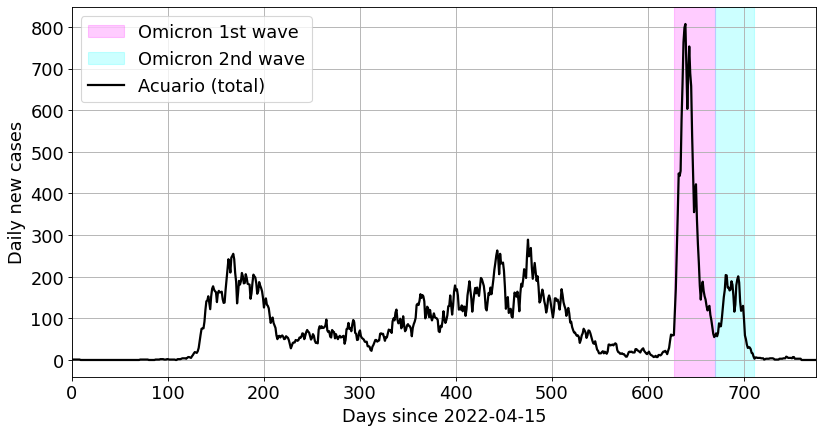

In [3]:
lwidth = 2
fsize = 16

fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

ax1.axvspan(omicron_start, omicron_end_1st, label='Omicron 1st wave', alpha=0.2, color='magenta')
ax1.axvspan(omicron_end_1st, omicron_end, label='Omicron 2nd wave', alpha=0.2, color='cyan')

ax1.plot(t, data_acuario_tot['new_cases'], 'k-', label='Acuario (total)', lw=lwidth)

ax1.legend()
ax1.grid()
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Daily new cases')
ax1.set_xlabel('Days since 2022-04-15')

plt.savefig('datos_acuario.png', dpi=150)

## Model definition

In [4]:
model_spec = {
    "classes" : ["S", "IA", "IB", "IAB", "IBA", "RA", "RB", "R"],

    "S" : {
        "infection" : [ ["IA", "S", "-betaA"],
                        ["IB", "S", "-betaB"],
                        ["IBA", "S", "-betaA"],
                        ["IAB", "S", "-betaB"]],
        "linear" :     [["S", "-new_var_kickB"]], # generate cases from new variant
    },

    "IA" : {
        "linear"    : [ ["IA", "-gamma"]],
        "infection" : [ ["IA", "S", "betaA"],
                        ["IBA", "S", "betaA"]]
    },

    "IB" : {
        "linear"    : [ ["IB", "-gamma"],
                        ["S", "new_var_kickB"]], # generate cases from new variant
        "infection" : [ ["IB", "S", "betaB"],
                        ["IAB", "S", "betaB"]]
    },

    "RA" : { # recovered from IA, suceptible to IB
        "linear"    : [ ["IA", "gamma"]],
        "infection" : [ ["IB", "RA", "-betaB"],
                        ["IAB", "RA", "-betaB"]]
    },
    
    "RB" : { # recovered from IB, suceptible to IA
        "linear"    : [ ["IB", "gamma"]],
        "infection" : [ ["IA", "RB", "-betaA"],
                        ["IBA", "RB", "-betaA"]]
    },
    
    "IAB" : { # infected with A, then B
        "linear"    : [ ["IAB", "-gamma"]],
        "infection" : [ ["IB", "RA", "betaB"],
                        ["IAB", "RA", "betaB"]]
    },

    "IBA" : { # infected with B, then A
        "linear"    : [ ["IBA", "-gamma"]],
        "infection" : [ ["IA", "RB", "betaA"],
                        ["IBA", "RB", "betaA"]]
    },

    "R" : { # recovered from both
        "linear"    : [ ["IAB", "gamma"],
                        ["IBA", "gamma"]]
    }
}

model_spec

{'classes': ['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'],
 'S': {'infection': [['IA', 'S', '-betaA'],
   ['IB', 'S', '-betaB'],
   ['IBA', 'S', '-betaA'],
   ['IAB', 'S', '-betaB']],
  'linear': [['S', '-new_var_kickB']]},
 'IA': {'linear': [['IA', '-gamma']],
  'infection': [['IA', 'S', 'betaA'], ['IBA', 'S', 'betaA']]},
 'IB': {'linear': [['IB', '-gamma'], ['S', 'new_var_kickB']],
  'infection': [['IB', 'S', 'betaB'], ['IAB', 'S', 'betaB']]},
 'RA': {'linear': [['IA', 'gamma']],
  'infection': [['IB', 'RA', '-betaB'], ['IAB', 'RA', '-betaB']]},
 'RB': {'linear': [['IB', 'gamma']],
  'infection': [['IA', 'RB', '-betaA'], ['IBA', 'RB', '-betaA']]},
 'IAB': {'linear': [['IAB', '-gamma']],
  'infection': [['IB', 'RA', 'betaB'], ['IAB', 'RA', 'betaB']]},
 'IBA': {'linear': [['IBA', '-gamma']],
  'infection': [['IA', 'RB', 'betaA'], ['IBA', 'RB', 'betaA']]},
 'R': {'linear': [['IAB', 'gamma'], ['IBA', 'gamma']]}}

Parameter values:

In [5]:
betaA = 0.37
betaB = 0.5
gamma = 0.35
new_var_kickB = 0
start_timeB = 40
parameters = {
    'betaA' : betaA,
    'betaB' : betaB,
    'gamma' : gamma,
    'new_var_kickB' : new_var_kickB,
    'start_timeB': start_timeB
}

In [6]:
def parameter_mapping(input_parameters, t):
    output_parameters = {
        'betaA' : input_parameters['betaA'],
        'betaB' : input_parameters['betaB'],
        'gamma' : input_parameters['gamma'],
        'start_timeB' : input_parameters['start_timeB'],
    }
    start_timeB = input_parameters['start_timeB']
    if t>start_timeB and t<start_timeB+1:
        output_parameters['new_var_kickB'] = input_parameters['new_var_kickB']
    else:
        output_parameters['new_var_kickB'] = 0

    return output_parameters

## Synthetic data
Single age group

In [7]:
N_pop = 4000

In [8]:
M = 1
Ni = N_pop*np.ones(M)
N = np.sum(Ni) 

if M==2:
    IA0 = np.array([5.0, 0.0])
    IB0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron_1st.iloc[0])
    IB0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'RA' : RA0,
    'RB' : RB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.identity(M)*2

# duration of simulation and data file
Tf = len(data_acuario_tot_omicron_1st) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

Plot time series

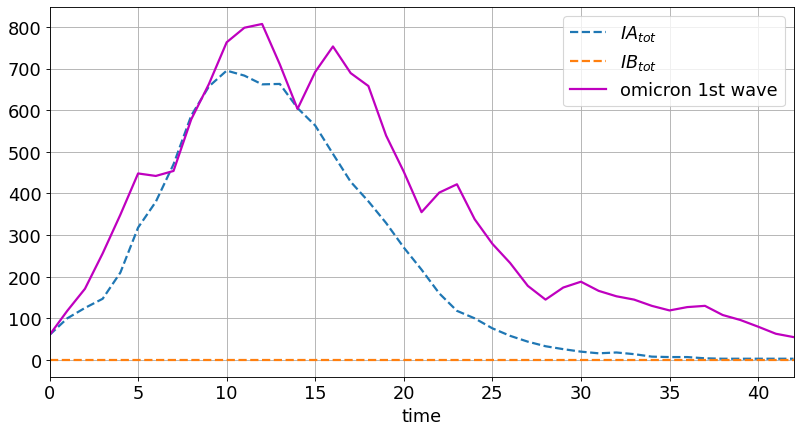

In [9]:
fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)
t = data['t']

IA = np.sum(model.model_class_data('IA',data), axis=1)
IB = np.sum(model.model_class_data('IB',data), axis=1)
IAB = np.sum(model.model_class_data('IAB',data), axis=1)
IBA = np.sum(model.model_class_data('IBA',data), axis=1)

ax1.plot(t, IA+IBA, '--', label='$IA_{tot}$', lw=lwidth)
ax1.plot(t, IB+IAB, '--', label='$IB_{tot}$', lw=lwidth)

ax1.plot(t, data_acuario_tot_omicron_1st['new_cases'], 'm-', label='omicron 1st wave', lw=lwidth)

plt.legend()
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [57]:
Tf_inference_1st = 40#45
Tf_inference_1st_v1 = 15#20
Tf_inference_1st_v2 = 10#12
Tf_inference_1st_v3 = 5#10

N_runs = 10 # number of runs with fitted parameters

## Inference: fit single peak, no prediction (omicron 1st wave)

In [11]:
N_start = 0
Tf_inference = Tf_inference_1st
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [12]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 0. 0. 1. 0. 0. 0.]]
(41, 8)
(41, 1)


In [13]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

1434.8615563921246
0.07180166244506836


#### Priors

In [14]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [15]:
# optimisation parameters 
ftol = 1e-10#1e-8 # the relative tol in (-logp)  
global_atol = 0.001#0.1

global_max_iter = 2000
local_max_iter = 1000
#objective_fun = 'least_squares'
objective_fun = 'likelihood'

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1st = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=160063854, Mon Oct 17 13:54:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 5.591242657428209e+02 1.0e+00 9.60e-01  3e-01  9e+01 0:00.6
    2     32 4.419407935425546e+02 1.2e+00 8.85e-01  3e-01  9e+01 0:01.1
    3     48 4.395180758775043e+02 1.3e+00 8.67e-01  3e-01  9e+01 0:01.5
   10    160 5.190540842688637e+02 1.9e+00 8.02e-01  2e-01  1e+02 0:04.9
   19    304 7.642154904273106e+02 2.6e+00 4.30e-01  1e-01  4e+01 0:08.9
   31    496 4.960257176429187e+02 3.1e+00 3.21e-01  6e-02  3e+01 0:14.1
   45    720 4.368058056091524e+02 8.6e+00 3.68e-01  3e-02  4e+01 0:20.2
   62    992 4.217179785577705e+02 2.5e+01 1.86e-01  8e-03  2e+01 0:27.4
   81   1296 3.910844031835962e+02 2.7e+01 1.18e-01  4e-03  1e+01 0:35.6
  100   1600 3.847414017255489e+02 2.3e+01 6.22e-02  2e-03  6e+00 0:44.0
  118   1888 3.654765888780707e+02 2.5e+01 2.69e-02  9e-04  2e+00 0:54.

In [16]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1st = res_omicron1st['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1st)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1st = res_omicron1st['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1st.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1st, map_x0_omicron1st, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.2787405846986888, 'betaB': 0.5, 'gamma': 0.20999424318204526, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3999   60    0    0    0    0    0    0]

 log p for best estimates:
379.8431801815936


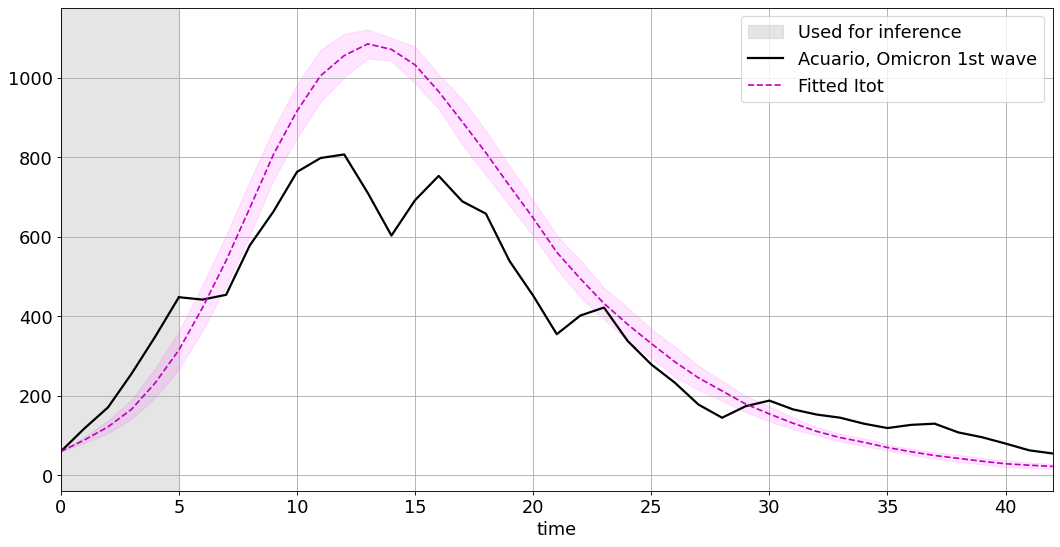

In [58]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1st
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron_1st['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron_1st['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1st, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

Itot_fit_omicron1st_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron1st_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_mean-Itot_fit_omicron1st_std,Itot_fit_omicron1st_mean+Itot_fit_omicron1st_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## Inference: fit partial peak (v1), with prediction

In [18]:
M = 1
Ni = N_pop*np.ones(M)
N = np.sum(Ni) 

if M==2:
    IA0 = np.array([5.0, 0.0])
    IB0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron_1st.iloc[0])
    IB0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'RA' : RA0,
    'RB' : RB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.identity(M)*2

# duration of simulation and data file
Tf = len(data_acuario_tot_omicron_1st) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

In [19]:
N_start = 0
Tf_inference = Tf_inference_1st_v1
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [20]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 0. 0. 1. 0. 0. 0.]]
(16, 8)
(16, 1)


In [21]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [22]:
estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1stpartial_v1 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=1117925031, Mon Oct 17 14:02:50 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.245444725536153e+02 1.0e+00 9.30e-01  3e-01  9e+01 0:00.3
    2     32 1.913371791393196e+02 1.3e+00 8.72e-01  3e-01  9e+01 0:00.6
    3     48 2.078670149654667e+02 1.3e+00 9.54e-01  3e-01  1e+02 0:00.9
   15    240 2.579764601560993e+02 2.7e+00 7.47e-01  2e-01  8e+01 0:04.1
   30    480 1.910728066241790e+02 5.4e+00 4.40e-01  8e-02  5e+01 0:08.2
   49    784 1.537657683354703e+02 1.2e+01 1.65e-01  1e-02  2e+01 0:13.2
   72   1152 1.308837212717375e+02 1.7e+01 3.94e-02  3e-03  5e+00 0:19.2
   99   1584 1.086360353905976e+02 1.8e+01 7.33e-03  3e-04  1e+00 0:26.3
  100   1600 1.088631275215252e+02 1.9e+01 6.55e-03  3e-04  8e-01 0:26.5
  135   2160 8.506524102908145e+01 2.3e+01 7.84e-04  2e-05  9e-02 0:35.7
  173   2768 7.155763881677011e+01 7.6e+01 9.96e-05  7e-07  1e-02 0:45

In [23]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1stpartial_v1 = res_omicron1stpartial_v1['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1stpartial_v1)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1stpartial_v1 = res_omicron1stpartial_v1['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1stpartial_v1.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1stpartial_v1, map_x0_omicron1stpartial_v1, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.3505250031784734, 'betaB': 0.5, 'gamma': 0.29299080615947515, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3925   59    0    0    0    0    0    0]

 log p for best estimates:
139.675481470929


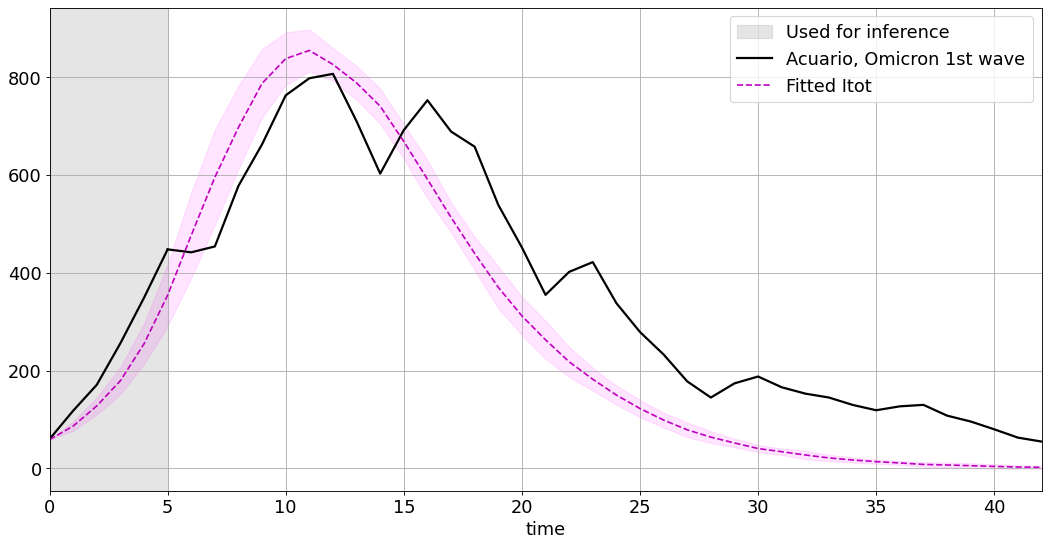

In [59]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1stpartial_v1
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron_1st['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron_1st['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1stpartial_v1, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

Itot_fit_omicron1st_v1_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron1st_v1_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v1_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v1_mean-Itot_fit_omicron1st_v1_std,Itot_fit_omicron1st_v1_mean+Itot_fit_omicron1st_v1_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## Inference: fit partial peak (v2), with prediction

In [25]:
M = 1
Ni = N_pop*np.ones(M)
N = np.sum(Ni) 

if M==2:
    IA0 = np.array([5.0, 0.0])
    IB0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron_1st.iloc[0])
    IB0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'RA' : RA0,
    'RB' : RB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.identity(M)*2

# duration of simulation and data file
Tf = len(data_acuario_tot_omicron_1st) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

In [26]:
N_start = 0
Tf_inference = Tf_inference_1st_v2
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [27]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 0. 0. 1. 0. 0. 0.]]
(11, 8)
(11, 1)


In [28]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [29]:
estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1stpartial_v2 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=1408609777, Mon Oct 17 14:04:28 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.429597092546691e+02 1.0e+00 9.74e-01  3e-01  1e+02 0:00.3
    2     32 1.319795604692232e+02 1.3e+00 9.21e-01  3e-01  1e+02 0:00.5
    3     48 1.476487655610586e+02 1.3e+00 9.30e-01  3e-01  1e+02 0:00.8
   14    224 1.630777239869814e+02 2.2e+00 1.21e+00  3e-01  1e+02 0:03.8
   30    480 1.415598776450165e+02 3.4e+00 1.12e+00  2e-01  1e+02 0:08.0
   50    800 1.274143057239957e+02 9.1e+00 7.76e-01  1e-01  8e+01 0:13.1
   74   1184 9.691002350307659e+01 2.6e+01 4.25e-01  3e-02  5e+01 0:19.1
  100   1600 5.560153937089990e+01 2.2e+01 1.23e-01  8e-03  1e+01 0:25.7
  132   2112 2.684917201791599e+01 2.0e+01 3.80e-02  2e-03  4e+00 0:33.8
  168   2688 -1.776654467189759e+01 2.2e+01 3.65e-03  9e-05  3e-01 0:43.0
  200   3200 -3.868445587990938e+01 2.7e+01 5.06e-04  6e-06  4e-02 0:

In [30]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1stpartial_v2 = res_omicron1stpartial_v2['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1stpartial_v2)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1stpartial_v2 = res_omicron1stpartial_v2['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1stpartial_v2.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1stpartial_v2, map_x0_omicron1stpartial_v2, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.40292123464744, 'betaB': 0.5, 'gamma': 0.3527652082123341, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3960   60    0    0    0    0    0    0]

 log p for best estimates:
72.3856238067927


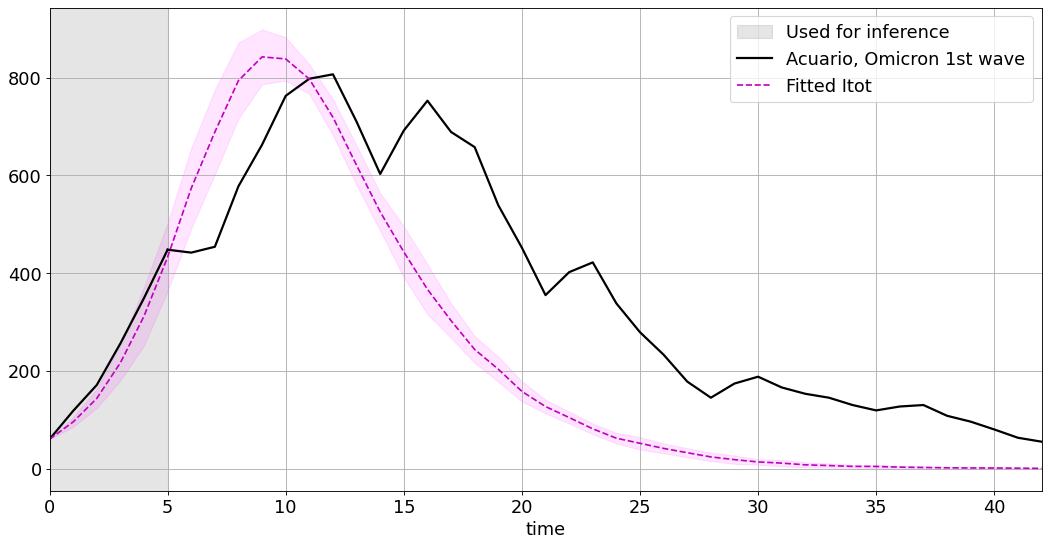

In [60]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1stpartial_v2
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron_1st['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron_1st['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1stpartial_v2, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

Itot_fit_omicron1st_v2_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron1st_v2_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v2_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v2_mean-Itot_fit_omicron1st_v2_std,Itot_fit_omicron1st_v2_mean+Itot_fit_omicron1st_v2_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## Inference: fit partial peak (v3), with prediction

In [32]:
M = 1
Ni = N_pop*np.ones(M)
N = np.sum(Ni) 

if M==2:
    IA0 = np.array([5.0, 0.0])
    IB0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron_1st.iloc[0])
    IB0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'RA' : RA0,
    'RB' : RB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.identity(M)*2

# duration of simulation and data file
Tf = len(data_acuario_tot_omicron_1st) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

In [33]:
N_start = 0
Tf_inference = Tf_inference_1st_v3
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3940   60    0    0    0    0    0    0]


In [34]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_tot_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 1. 0. 0. 1. 0. 0. 0.]]
(6, 8)
(6, 1)


In [35]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [*Ni*0.99, eps, eps, eps, eps, eps, eps],
        'std': [100, 1, 1, 1, 1, 1, 1],
        'bounds': [[*Ni*0.9, *Ni], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True, False,  True,  True,  True,  True,  True,  True]),
  'mean': [3960.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
  'std': [100, 1, 1, 1, 1, 1, 1],
  'bounds': [[3600.0, 4000.0],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [36]:
estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1stpartial_v3 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 9 (seed=2974563930, Mon Oct 17 14:07:08 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 7.203717873880315e+01 1.0e+00 8.86e-01  3e-01  9e+01 0:00.3
    2     32 6.582362372629042e+01 1.2e+00 7.32e-01  2e-01  7e+01 0:00.5
    3     48 4.271147341942424e+01 1.2e+00 6.47e-01  2e-01  6e+01 0:00.8
   15    240 3.336694178288278e+01 3.3e+00 3.26e-01  9e-02  3e+01 0:04.0
   30    480 6.506310141732484e+00 5.9e+00 1.46e-01  3e-02  1e+01 0:08.0
   51    816 -1.135937971321983e+01 7.7e+00 5.60e-02  6e-03  6e+00 0:13.2
   76   1216 -4.014609933721539e+01 9.4e+00 1.59e-02  9e-04  2e+00 0:19.4
  100   1600 -6.379552898667801e+01 1.6e+01 4.10e-03  1e-04  4e-01 0:25.5
  134   2144 -8.648807903233561e+01 4.9e+01 1.28e-03  2e-05  2e-01 0:33.8
  170   2720 -1.033488344540302e+02 7.3e+01 2.65e-04  2e-06  4e-02 0:42.9
  200   3200 -1.189016806028585e+02 8.1e+01 2.71e-05  1e-07  3e-0

In [37]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1stpartial_v3 = res_omicron1stpartial_v3['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1stpartial_v3)

print('\n True initial conditions: ') 
#print((obs[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1stpartial_v3 = res_omicron1stpartial_v3['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1stpartial_v3.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1stpartial_v3, map_x0_omicron1stpartial_v3, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.6193373505527693, 'betaB': 0.5, 'gamma': 0.7134481298851406, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 60, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3983   60    0    0    0    0    0    0]

 log p for best estimates:
21.02624556097102


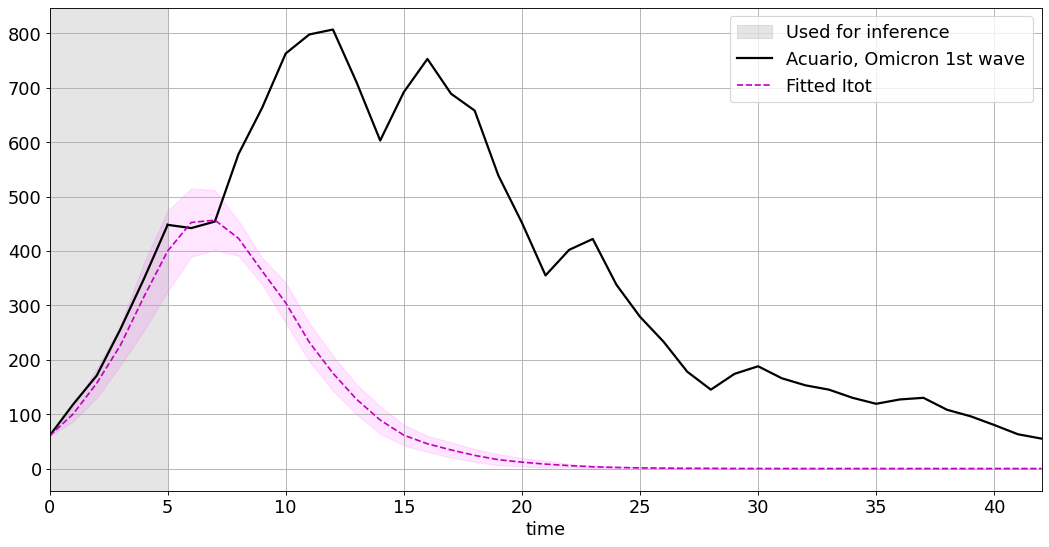

In [63]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1stpartial_v3
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_tot_omicron_1st['new_cases'][:N_start+Tf_inference+1], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_tot_omicron_1st['new_cases'][N_start+Tf_inference:], 'k-', lw=lwidth)

# show stochastic variability
IA_fit = np.zeros([N_runs,Nf],dtype=float)
IB_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1stpartial_v3, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_fit[loop] = np.sum(model_fit.model_class_data('IA',data_fit), axis=1)
    IB_fit[loop] = np.sum(model_fit.model_class_data('IB',data_fit), axis=1)
    IAB_fit[loop] = np.sum(model_fit.model_class_data('IAB',data_fit), axis=1)
    IBA_fit[loop] = np.sum(model_fit.model_class_data('IBA',data_fit), axis=1)

Itot_fit_omicron1st_v3_mean = np.mean(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)
Itot_fit_omicron1st_v3_std = np.std(IA_fit+IB_fit+IAB_fit+IBA_fit,axis=0)

plt.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v3_mean, 'm--',label='Fitted Itot')
plt.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v3_mean-Itot_fit_omicron1st_v3_std,Itot_fit_omicron1st_v3_mean+Itot_fit_omicron1st_v3_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

### Compare among fittings

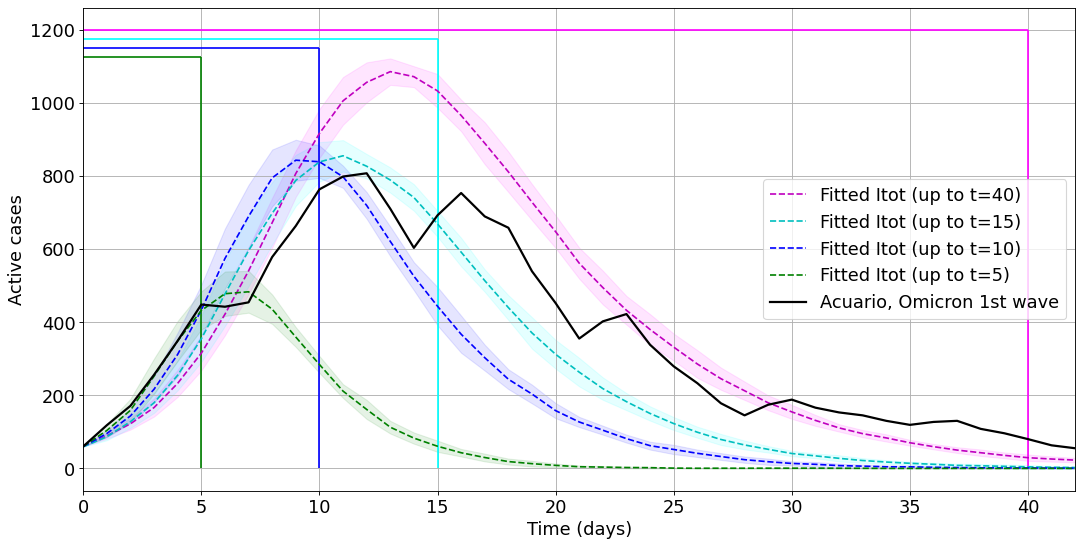

In [62]:
limit_1st = 1200
limit_1st_v1 = 1175
limit_1st_v2 = 1150
limit_1st_v3 = 1125

fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

t = data['t']

ax1.vlines(Tf_inference_1st, 0, limit_1st, colors='magenta', linestyles='-')
ax1.vlines(Tf_inference_1st_v1, 0, limit_1st_v1, colors='cyan', linestyles='-')
ax1.vlines(Tf_inference_1st_v2, 0, limit_1st_v2, colors='blue', linestyles='-')
ax1.vlines(Tf_inference_1st_v3, 0, limit_1st_v3, colors='green', linestyles='-')
ax1.hlines(limit_1st, 0, Tf_inference_1st, colors='magenta', linestyles='-')
ax1.hlines(limit_1st_v1, 0, Tf_inference_1st_v1, colors='cyan', linestyles='-')
ax1.hlines(limit_1st_v2, 0, Tf_inference_1st_v2, colors='blue', linestyles='-')
ax1.hlines(limit_1st_v3, 0, Tf_inference_1st_v3, colors='green', linestyles='-')

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_mean, 'm--',label='Fitted Itot (up to t=' + str(Tf_inference_1st) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_mean-Itot_fit_omicron1st_std,Itot_fit_omicron1st_mean+Itot_fit_omicron1st_std,color='magenta', alpha=0.1)

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v1_mean, 'c--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v1) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v1_mean-Itot_fit_omicron1st_v1_std,Itot_fit_omicron1st_v1_mean+Itot_fit_omicron1st_v1_std,color='cyan', alpha=0.1)

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v2_mean, 'b--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v2) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v2_mean-Itot_fit_omicron1st_v2_std,Itot_fit_omicron1st_v2_mean+Itot_fit_omicron1st_v2_std,color='blue', alpha=0.1)

ax1.plot(t[N_start:Nf+N_start], Itot_fit_omicron1st_v3_mean, 'g--',label='Fitted Itot (up to t=' + str(Tf_inference_1st_v3) + ')')
ax1.fill_between(t[N_start:Nf+N_start],Itot_fit_omicron1st_v3_mean-Itot_fit_omicron1st_v3_std,Itot_fit_omicron1st_v3_mean+Itot_fit_omicron1st_v3_std,color='green', alpha=0.1)


ax1.plot(t, data_acuario_tot_omicron_1st['new_cases'], 'k-', label='Acuario, Omicron 1st wave', lw=lwidth)


plt.legend(fontsize=16, loc='right')
plt.grid() 
plt.xlabel(r'Time (days)') 
plt.ylabel(r'Active cases') 
plt.autoscale(enable=True, axis='x', tight=True)

plt.savefig('acuario_fit_singlepeak.pdf')
plt.savefig('acuario_fit_singlepeak.png', dpi=72)

In [51]:
with open("acuario_fit_singlepeak.pkl", "wb") as f:
    pickle.dump([{"Itot_fit_omicron1st_mean": Itot_fit_omicron1st_mean, "Itot_fit_omicron1st_std": Itot_fit_omicron1st_std,
                "Itot_fit_omicron1st_v1_mean": Itot_fit_omicron1st_v1_mean, "Itot_fit_omicron1st_v1_std": Itot_fit_omicron1st_v1_std,
                "Itot_fit_omicron1st_v2_mean": Itot_fit_omicron1st_v2_mean, "Itot_fit_omicron1st_v2_std": Itot_fit_omicron1st_v2_std,
                "Itot_fit_omicron1st_v3_mean": Itot_fit_omicron1st_v3_mean, "Itot_fit_omicron1st_v3_std": Itot_fit_omicron1st_v3_std,
                "data_acuario_tot_omicron_1st": data_acuario_tot_omicron_1st,
                 "res_omicron1st": res_omicron1st,
                 "res_omicron1st_partial_v1": res_omicron1st_partial_v1,
                 "res_omicron1st_partial_v2": res_omicron1st_partial_v2,
                 "res_omicron1st_partial_v3": res_omicron1st_partial_v3}], f)



In [177]:
with open('acuario_fit_singlepeak.pkl', 'rb') as file:
    myvar = pickle.load(file)

from types import SimpleNamespace
n = SimpleNamespace(**myvar[0])
n.Itot_fit_omicron1st_mean

## Two age groups

In [157]:
df = pd.read_csv('../../bjornstad2python/PyRoss/I_cc_edades_iguales.csv', index_col=0)
data_acuario_age = pd.DataFrame()
data_acuario_age['age_0'] = df.iloc[:,0::2].sum(axis=1)
data_acuario_age['age_1'] = df.iloc[:,1::2].sum(axis=1)

t = range(0, len(data_acuario_age))
omicron_start = 627
omicron_end_1st = 670
omicron_end = 710
data_acuario_age_omicron = data_acuario_age.iloc[omicron_start:omicron_end]
data_acuario_age_omicron_1st = data_acuario_age.iloc[omicron_start:omicron_end_1st]

data_acuario_age_omicron

,age_0,age_1
2022-01-02,35.0,28.0
2022-01-03,71.0,50.0
2022-01-04,105.0,70.0
2022-01-05,150.0,114.0
2022-01-06,207.0,147.0
...,...,...
2022-03-21,22.0,10.0
2022-03-22,21.0,10.0
2022-03-23,17.0,10.0
2022-03-24,12.0,4.0


Text(0.5, 0, 'Days since 2022-04-15')

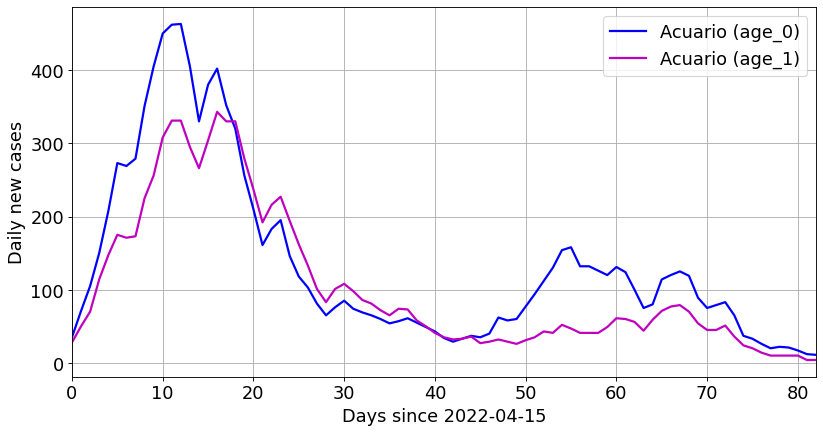

In [158]:
lwidth = 2
fsize = 16

t_omicron = range(0, len(data_acuario_age_omicron))

fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

ax1.plot(t_omicron, data_acuario_age_omicron['age_0'], 'b-', label='Acuario (age_0)', lw=lwidth)
ax1.plot(t_omicron, data_acuario_age_omicron['age_1'], 'm-', label='Acuario (age_1)', lw=lwidth)

ax1.legend()
ax1.grid()
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Daily new cases')
ax1.set_xlabel('Days since 2022-04-15')


In [159]:
betaA = 0.37
betaB = 0.5
gamma = 0.35
new_var_kickB = 0
start_timeB = 40
parameters = {
    'betaA' : betaA,
    'betaB' : betaB,
    'gamma' : gamma,
    'new_var_kickB' : new_var_kickB,
    'start_timeB': start_timeB
}

In [160]:
def parameter_mapping(input_parameters, t):
    output_parameters = {
        'betaA' : input_parameters['betaA'],
        'betaB' : input_parameters['betaB'],
        'gamma' : input_parameters['gamma'],
        'start_timeB' : input_parameters['start_timeB'],
    }
    start_timeB = input_parameters['start_timeB']
    if t>start_timeB and t<start_timeB+1:
        output_parameters['new_var_kickB'] = input_parameters['new_var_kickB']
    else:
        output_parameters['new_var_kickB'] = 0

    return output_parameters

In [161]:
N_pop = 4000

In [162]:
M = 2
Ni = N_pop*np.ones(M)
N = np.sum(Ni)

if M==2:
    IA0 = np.array(data_acuario_age_omicron.iloc[0])
    IB0 = np.array([0.0, 0.0])
    RA0 = np.array([0.0, 0.0])
    RB0 = np.array([0.0, 0.0])
    IAB0 = np.array([0.0, 0.0])
    IBA0 = np.array([0.0, 0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0, 0.0])
else:
    IA0 = np.array(data_acuario_tot_omicron.iloc[0])
    IB0 = np.array([0.0])
    RA0 = np.array([0.0])
    RB0 = np.array([0.0])
    IAB0 = np.array([0.0])
    IBA0 = np.array([0.0])
    S0 = Ni - (IA0 + IB0 + IAB0 + IBA0)
    R0 = np.array([0.0])

x0 = {
    'S' : S0,
    'IA' : IA0,
    'IB' : IB0,
    'RA' : RA0,
    'RB' : RB0,
    'IAB' : IAB0,
    'IBA' : IBA0,
    'R' : R0
}

# the contact matrix is time-dependent
def contactMatrix(t):
    return np.array([[2,1],[1,1]]).astype('float')*0.65

# duration of simulation and data file
Tf = len(data_acuario_age_omicron_1st) - 1
Nf = Tf + 1

# model instantiation
model = pyross.stochastic.Model(model_spec, parameters, M, Ni, time_dep_param_mapping=parameter_mapping)

# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

# just in case, save synthetic data
data_array = data['X'].astype('float')
x = data_array

Plot time series

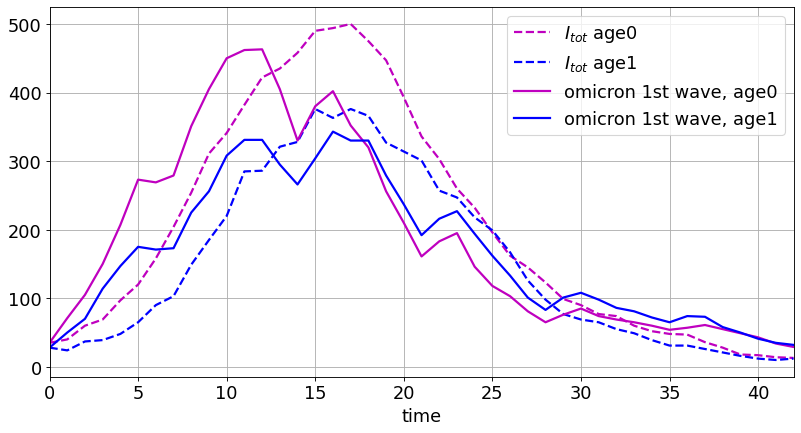

In [163]:
fig1 = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)
t = data['t']

IA_age0 = model.model_class_data('IA',data)[:,0]
IB_age0 = model.model_class_data('IB',data)[:,0]
IAB_age0 = model.model_class_data('IAB',data)[:,0]
IBA_age0 = model.model_class_data('IBA',data)[:,0]
IA_age1 = model.model_class_data('IA',data)[:,1]
IB_age1 = model.model_class_data('IB',data)[:,1]
IAB_age1 = model.model_class_data('IAB',data)[:,1]
IBA_age1 = model.model_class_data('IBA',data)[:,1]

Itot_age0 = IA_age0 + IB_age0 + IBA_age0 + IAB_age0
Itot_age1 = IA_age1 + IB_age1 + IBA_age1 + IAB_age1

ax1.plot(t, Itot_age0, 'm--', label='$I_{tot}$ age0', lw=lwidth)
ax1.plot(t, Itot_age1, 'b--', label='$I_{tot}$ age1', lw=lwidth)

ax1.plot(t, data_acuario_age_omicron_1st['age_0'], 'm-', label='omicron 1st wave, age0', lw=lwidth)
ax1.plot(t, data_acuario_age_omicron_1st['age_1'], 'b-', label='omicron 1st wave, age1', lw=lwidth)

plt.legend()
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [164]:
Tf_inference_1st = 40
Tf_inference_1st_v1 = 15
Tf_inference_1st_v2 = 10
Tf_inference_1st_v3 = 5

N_runs = 10 # number of runs with fitted parameters

## Inference: fit single peak, no prediction

In [165]:
N_start = 0
Tf_inference = Tf_inference_1st
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3965 3972   35   28    0    0    0    0    0    0    0    0    0    0
    0    0]


In [166]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_age_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(41, 16)
(41, 2)


In [167]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': np.repeat([N_pop, eps, eps, eps, eps, eps, eps],M),
        'std': np.repeat([100, 1, 1, 1, 1, 1, 1],M),
        'bounds': [[N_pop*0.9, N_pop], [N_pop*0.9, N_pop], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True,  True, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True]),
  'mean': array([4.e+03, 4.e+03, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
         1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04]),
  'std': array([100, 100,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1]),
  'bounds': [[3600.0, 4000],
   [3600.0, 4000],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [168]:
# optimisation parameters 
ftol = 1e-10#1e-8 # the relative tol in (-logp)  
global_atol = 0.001#0.1

global_max_iter = 2000
local_max_iter = 1000
#objective_fun = 'least_squares'
objective_fun = 'likelihood'

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1st = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 16 (seed=454828088, Thu Oct 20 08:37:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.306727846443553e+03 1.0e+00 9.28e-01  3e-01  9e+01 0:00.8
    2     32 8.979545788689817e+02 1.1e+00 8.99e-01  3e-01  9e+01 0:01.4
    3     48 2.161570275552098e+03 1.2e+00 8.95e-01  3e-01  1e+02 0:02.0
    9    144 6.116259102446204e+02 1.4e+00 7.96e-01  3e-01  8e+01 0:05.1
   17    272 7.086912026688294e+02 1.6e+00 6.31e-01  2e-01  6e+01 0:09.4
   27    432 6.705989797103050e+02 1.9e+00 5.39e-01  2e-01  5e+01 0:14.8
   40    640 5.726721570203662e+02 2.6e+00 5.43e-01  2e-01  6e+01 0:21.3
   55    880 6.176856374887964e+02 4.3e+00 4.71e-01  1e-01  6e+01 0:28.6
   72   1152 5.673026378512697e+02 7.8e+00 5.75e-01  9e-02  7e+01 0:36.8
   91   1456 5.235410746410354e+02 1.2e+01 3.15e-01  3e-02  4e+01 0:45.8
  100   1600 5.210025852827168e+02 1.3e+01 2.01e-01  2e-02  3e+01 0:50

In [169]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1st_age = res_omicron1st['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1st_age)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1st_age = res_omicron1st['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1st_age.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1st_age, map_x0_omicron1st_age, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.3629505361895201, 'betaB': 0.5, 'gamma': 0.3237125655243066, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 35, 28, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3998 3987   35   28    0    0    0    0    0    0    0    0    0    0
    0    0]

 log p for best estimates:
429.23305172634093


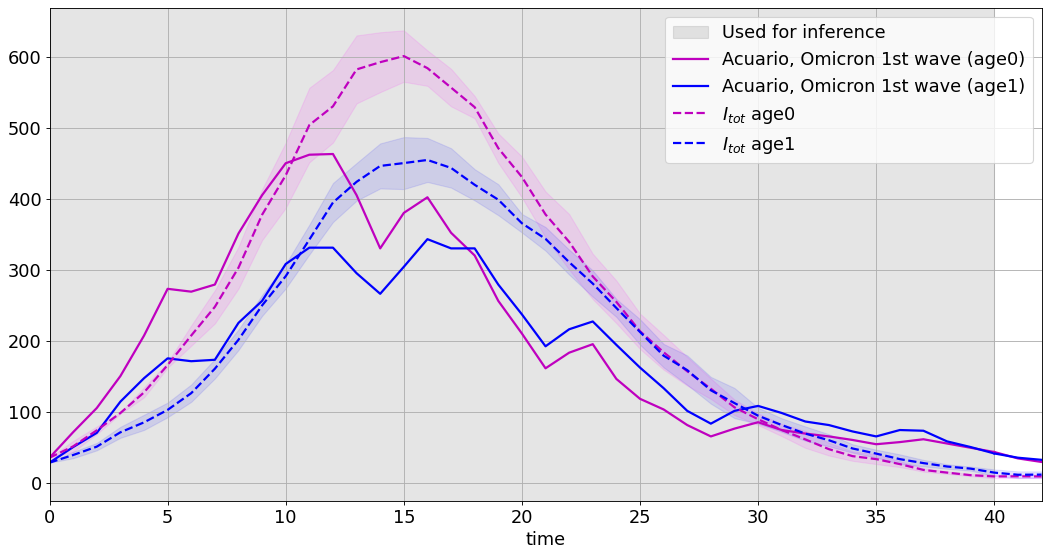

In [170]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1st_age
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_age_omicron_1st['age_0'][:N_start+Tf_inference+1], 'm-', label='Acuario, Omicron 1st wave (age0)', lw=lwidth)
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_age_omicron_1st['age_1'][:N_start+Tf_inference+1], 'b-', label='Acuario, Omicron 1st wave (age1)', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_age_omicron_1st['age_0'][N_start+Tf_inference:], 'm-', lw=lwidth)
    ax1.plot(t[N_start+Tf_inference:], data_acuario_age_omicron_1st['age_1'][N_start+Tf_inference:], 'b-', lw=lwidth)



# show stochastic variability
N_runs = 5
IA_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IB_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IA_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IB_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_age1_fit = np.zeros([N_runs,Nf],dtype=float)
Itot_age0_fit = np.zeros([N_runs,Nf],dtype=float)
Itot_age1_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1st_age, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_age0_fit[loop] = model_fit.model_class_data('IA',data_fit)[:,0]
    IB_age0_fit[loop] = model_fit.model_class_data('IB',data_fit)[:,0]
    IAB_age0_fit[loop] = model_fit.model_class_data('IAB',data_fit)[:,0]
    IBA_age0_fit[loop] = model_fit.model_class_data('IBA',data_fit)[:,0]
    IA_age1_fit[loop] = model_fit.model_class_data('IA',data_fit)[:,1]
    IB_age1_fit[loop] = model_fit.model_class_data('IB',data_fit)[:,1]
    IAB_age1_fit[loop] = model_fit.model_class_data('IAB',data_fit)[:,1]
    IBA_age1_fit[loop] = model_fit.model_class_data('IBA',data_fit)[:,1]

Itot_age0_fit = IA_age0_fit + IB_age0_fit + IBA_age0_fit + IAB_age0_fit
Itot_age1_fit = IA_age1_fit + IB_age1_fit + IBA_age1_fit + IAB_age1_fit
Itot_age0_fit_mean = np.mean(Itot_age0_fit,axis=0)
Itot_age1_fit_mean = np.mean(Itot_age1_fit,axis=0)
Itot_age0_fit_std = np.std(Itot_age0_fit,axis=0)
Itot_age1_fit_std = np.std(Itot_age1_fit,axis=0)

ax1.plot(t, Itot_age0_fit_mean, 'm--', label='$I_{tot}$ age0', lw=lwidth)
ax1.plot(t, Itot_age1_fit_mean, 'b--', label='$I_{tot}$ age1', lw=lwidth)
ax1.fill_between(t[N_start:Nf+N_start],Itot_age0_fit_mean-Itot_age0_fit_std,Itot_age0_fit_mean+Itot_age0_fit_std,color='magenta', alpha=0.1)
ax1.fill_between(t[N_start:Nf+N_start],Itot_age1_fit_mean-Itot_age1_fit_std,Itot_age1_fit_mean+Itot_age1_fit_std,color='blue', alpha=0.1)


plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## Inference: fit partial peak (v1), with prediction

In [171]:
N_start = 0
Tf_inference = Tf_inference_1st_v1
Nf_inference = Tf_inference + 1

x = data_array
x = x[N_start:N_start+Nf_inference]
print(x[0].astype('int'))

# initialise the estimator 
estimator = pyross.inference.Model(model_spec,parameters, M, Ni, steps=4, time_dep_param_mapping=parameter_mapping)

[3965 3972   35   28    0    0    0    0    0    0    0    0    0    0
    0    0]


In [172]:
# active cases
fltr = np.kron([0, 1, 0, 0, 1, 0, 0, 0],np.identity(M)) # note order of variables in model data
obs = data_acuario_age_omicron_1st.iloc[N_start:Nf_inference].to_numpy()
print(estimator.class_index_dict.keys())
print(fltr)
print(x.shape)
print(obs.shape)

dict_keys(['S', 'IA', 'IB', 'IAB', 'IBA', 'RA', 'RB', 'R'])
[[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
(16, 16)
(16, 2)


In [173]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
betaA_g, betaB_g, gamma_g, new_var_kickB_g, start_timeB_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'betaA':{
        'mean': betaA_g,
        'std': 2*betaA_g,
        'bounds': [eps, 4*betaA_g], 
        'prior_fun': 'truncnorm'
    },
    'gamma':{
        'mean': gamma_g,
        'std': 2*gamma_g,
        'bounds': [eps, 4*gamma_g],
        'prior_fun': 'truncnorm'
    }
}


pyross.utils.parse_param_prior_dict(param_priors, M)

# make initial value guesses and set up bounds for each initial value
init_fltr = np.repeat([True, False, True, True, True, True, True, True], M)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': np.repeat([N_pop, eps, eps, eps, eps, eps, eps],M),
        'std': np.repeat([100, 1, 1, 1, 1, 1, 1],M),
        'bounds': [[N_pop*0.9, N_pop], [N_pop*0.9, N_pop], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
    }
}

init_priors

{'independent': {'fltr': array([ True,  True, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True]),
  'mean': array([4.e+03, 4.e+03, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
         1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04]),
  'std': array([100, 100,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1]),
  'bounds': [[3600.0, 4000],
   [3600.0, 4000],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1],
   [0, 1]]}}

#### Actual fitting

In [174]:
estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods
start_time = time.time()
res_omicron1st_v1 = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=global_max_iter, global_atol=global_atol,
                                            objective=objective_fun,
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=local_max_iter)
end_time = time.time()
runtime_min, runtime_sec = divmod(round(end_time - start_time), 60)
print("Run time", f'{runtime_min:02d}:{runtime_sec:02d}', "minutes")

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 16 (seed=647656543, Thu Oct 20 08:57:09 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.663489680800062e+02 1.0e+00 9.06e-01  3e-01  9e+01 0:00.3
    2     32 2.536964486650132e+02 1.1e+00 8.33e-01  3e-01  8e+01 0:00.6
    3     48 2.796749702720477e+02 1.1e+00 8.13e-01  3e-01  8e+01 0:00.9
   13    208 3.203142584590469e+02 1.7e+00 9.67e-01  3e-01  9e+01 0:04.2
   26    416 3.146522728907122e+02 1.9e+00 1.04e+00  3e-01  1e+02 0:08.2
   44    704 3.272723793239554e+02 2.4e+00 1.09e+00  3e-01  1e+02 0:13.4
   64   1024 3.873808986559535e+02 3.1e+00 9.70e-01  3e-01  1e+02 0:19.6
   88   1408 2.809258470683552e+02 5.1e+00 5.04e-01  1e-01  6e+01 0:26.8
  100   1600 2.704945769867466e+02 7.1e+00 3.85e-01  6e-02  4e+01 0:31.1
  126   2016 2.516088616809540e+02 1.2e+01 2.09e-01  3e-02  3e+01 0:40.3
  160   2560 2.300291690062828e+02 1.7e+01 7.82e-02  9e-03  1e+01 0:50

In [175]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates_omicron1st_v1_age = res_omicron1st_v1['params_dict'].copy()
print('\n Best estimates')
print(best_estimates_omicron1st_v1_age)

print('\n True initial conditions: ') 
#print((x[0]).astype('int'))
print(['-', *obs[0].astype('int'), '-', '-', '-', '-', '-', '-'])#.astype('int'))


map_x0_omicron1st_v1_age = res_omicron1st_v1['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0_omicron1st_v1_age.astype('int'))

logp = estimator.minus_logp_red(best_estimates_omicron1st_v1_age, map_x0_omicron1st_v1_age, obs, fltr, Tf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'betaA': 0.37, 'betaB': 0.5, 'gamma': 0.35, 'new_var_kickB': 0, 'start_timeB': 40}

 Best estimates
{'betaA': 0.5188628549420046, 'betaB': 0.5, 'gamma': 0.5057794714937186, 'new_var_kickB': 0, 'start_timeB': 40}

 True initial conditions: 
['-', 35, 28, '-', '-', '-', '-', '-', '-']

 Inferred initial conditions: 
[3973 3985   35   27    0    0    0    0    0    0    0    0    0    0
    0    0]

 log p for best estimates:
167.35264225250143


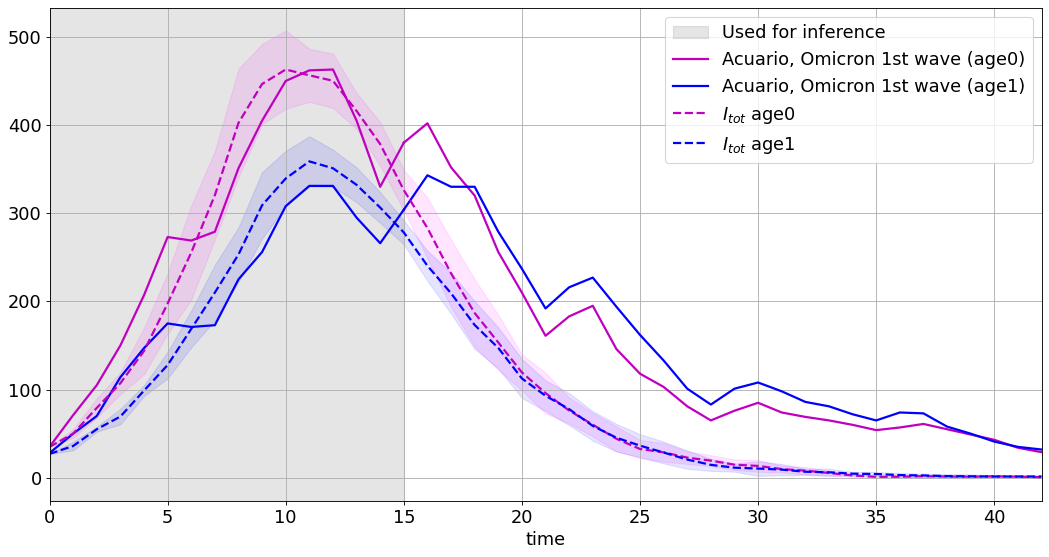

In [176]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': fsize})
ax1 = fig1.subplots(1,1)

x_start = map_x0_omicron1st_v1_age
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_age_omicron_1st['age_0'][:N_start+Tf_inference+1], 'm-', label='Acuario, Omicron 1st wave (age0)', lw=lwidth)
ax1.plot(t[:N_start+Tf_inference+1], data_acuario_age_omicron_1st['age_1'][:N_start+Tf_inference+1], 'b-', label='Acuario, Omicron 1st wave (age1)', lw=lwidth)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], data_acuario_age_omicron_1st['age_0'][N_start+Tf_inference:], 'm-', lw=lwidth)
    ax1.plot(t[N_start+Tf_inference:], data_acuario_age_omicron_1st['age_1'][N_start+Tf_inference:], 'b-', lw=lwidth)



# show stochastic variability
N_runs = 5
IA_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IB_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_age0_fit = np.zeros([N_runs,Nf],dtype=float)
IA_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IB_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IAB_age1_fit = np.zeros([N_runs,Nf],dtype=float)
IBA_age1_fit = np.zeros([N_runs,Nf],dtype=float)
Itot_age0_fit = np.zeros([N_runs,Nf],dtype=float)
Itot_age1_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec, best_estimates_omicron1st_v1_age, M, Ni, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    IA_age0_fit[loop] = model_fit.model_class_data('IA',data_fit)[:,0]
    IB_age0_fit[loop] = model_fit.model_class_data('IB',data_fit)[:,0]
    IAB_age0_fit[loop] = model_fit.model_class_data('IAB',data_fit)[:,0]
    IBA_age0_fit[loop] = model_fit.model_class_data('IBA',data_fit)[:,0]
    IA_age1_fit[loop] = model_fit.model_class_data('IA',data_fit)[:,1]
    IB_age1_fit[loop] = model_fit.model_class_data('IB',data_fit)[:,1]
    IAB_age1_fit[loop] = model_fit.model_class_data('IAB',data_fit)[:,1]
    IBA_age1_fit[loop] = model_fit.model_class_data('IBA',data_fit)[:,1]

Itot_age0_fit = IA_age0_fit + IB_age0_fit + IBA_age0_fit + IAB_age0_fit
Itot_age1_fit = IA_age1_fit + IB_age1_fit + IBA_age1_fit + IAB_age1_fit
Itot_age0_fit_v1_mean = np.mean(Itot_age0_fit,axis=0)
Itot_age1_fit_v1_mean = np.mean(Itot_age1_fit,axis=0)
Itot_age0_fit_v1_std = np.std(Itot_age0_fit,axis=0)
Itot_age1_fit_v1_std = np.std(Itot_age1_fit,axis=0)

ax1.plot(t, Itot_age0_fit_v1_mean, 'm--', label='$I_{tot}$ age0', lw=lwidth)
ax1.plot(t, Itot_age1_fit_v1_mean, 'b--', label='$I_{tot}$ age1', lw=lwidth)
ax1.fill_between(t[N_start:Nf+N_start],Itot_age0_fit_v1_mean-Itot_age0_fit_v1_std,Itot_age0_fit_v1_mean+Itot_age0_fit_v1_std,color='magenta', alpha=0.1)
ax1.fill_between(t[N_start:Nf+N_start],Itot_age1_fit_v1_mean-Itot_age1_fit_v1_std,Itot_age1_fit_v1_mean+Itot_age1_fit_v1_std,color='blue', alpha=0.1)


plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [51]:
with open("acuario_fit_singlepeak_age.pkl", "wb") as f:
    pickle.dump([{"Itot_age0_fit_mean": Itot_age0_fit_mean, "Itot_age0_fit_std": Itot_age0_fit_std,
                  "Itot_age1_fit_mean": Itot_age1_fit_mean, "Itot_age1_fit_std": Itot_age1_fit_std,
                "Itot_age0_fit_v1_mean": Itot_age0_fit_v1_mean, "Itot_age0_fit_v1_std": Itot_age0_fit_v1_std,
                "Itot_age1_fit_v1_mean": Itot_age1_fit_v1_mean, "Itot_age1_fit_v1_std": Itot_age1_fit_v1_std,
                "best_estimates_omicron1st_age": best_estimates_omicron1st_age,
                "best_estimates_omicron1st_v1_age": best_estimates_omicron1st_v1_age,
                "data_acuario_age_omicron_1st": data_acuario_age_omicron_1st}], f)
